/home/rameyjm7/workspace/TML/Project_1/lighteval_env/lib/python3.10/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


[INFO] Saved overlap summary → activations/activation_overlap_summary.csv
   Layer  Prompt_i  Prompt_j  Cosine_Overlap
0      0         1         2        0.894531
1      0         1         3        0.902392
2      0         1         4        0.887207
3      0         1         5        0.884334
4      0         2         3        0.894095


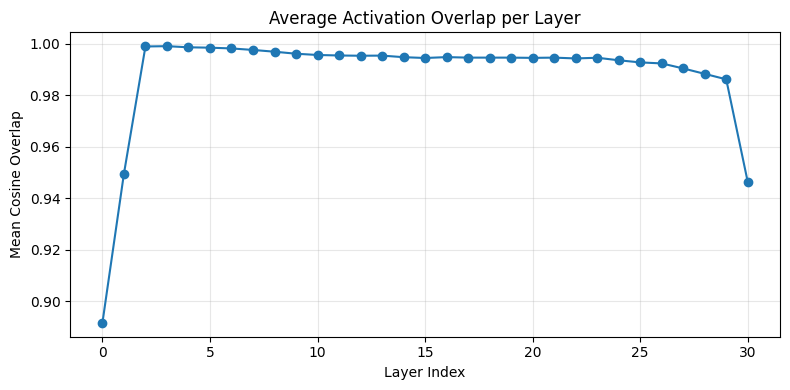

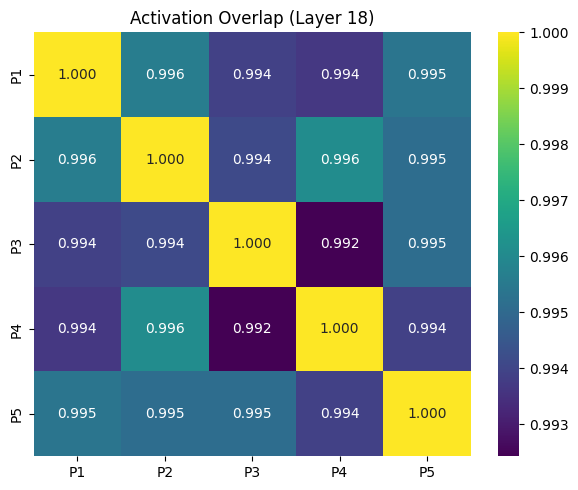

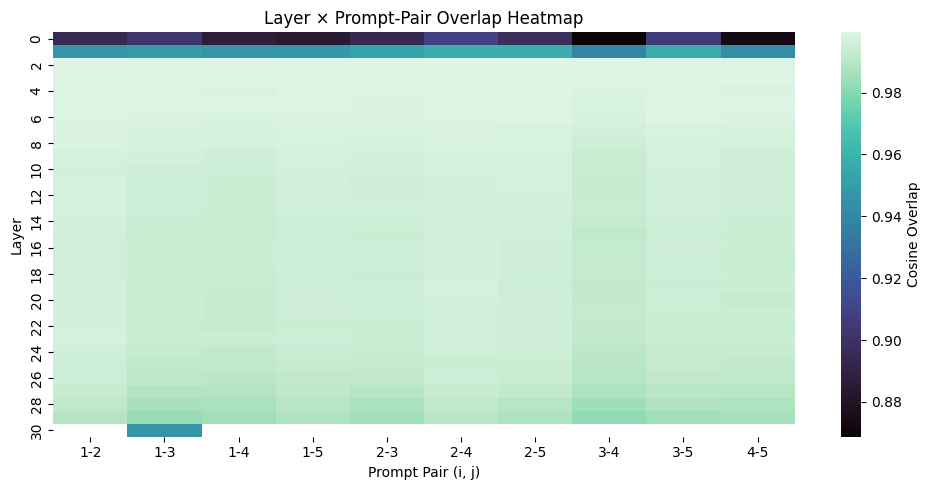

[INFO] Activation Overlap Analysis complete.


In [6]:
# ---------------------------------------------------------------------
# 3. Compute pairwise cosine overlap (normalized & robust)
# ---------------------------------------------------------------------
pair_records = []
for lid in layers:
    for (p1, p2) in combinations(prompts, 2):
        v1, v2 = activations[p1][lid], activations[p2][lid]
        if v1 is None or v2 is None:
            continue
        # normalize to unit length to avoid overflow
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        sim = 1 - cosine(v1, v2)
        pair_records.append({
            "Layer": lid,
            "Prompt_i": p1,
            "Prompt_j": p2,
            "Cosine_Overlap": sim
        })

df_overlap = pd.DataFrame(pair_records)
out_csv = os.path.join(base_dir, "activation_overlap_summary.csv")
df_overlap.to_csv(out_csv, index=False)
print(f"[INFO] Saved overlap summary → {out_csv}")
print(df_overlap.head())

# ---------------------------------------------------------------------
# 4. Visualization A — Mean overlap per layer
# ---------------------------------------------------------------------
layer_means = df_overlap.groupby("Layer")["Cosine_Overlap"].mean().reset_index()
plt.figure(figsize=(8,4))
plt.plot(layer_means["Layer"], layer_means["Cosine_Overlap"], marker="o")
plt.title("Average Activation Overlap per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Mean Cosine Overlap")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5. Visualization B — Mid-layer prompt-pair heatmap
# ---------------------------------------------------------------------
mid_layer = layers[len(layers)//2]
df_mid = df_overlap[df_overlap["Layer"] == mid_layer]

# build mapping from prompt ID → matrix index
id_to_idx = {pid: idx for idx, pid in enumerate(prompts)}
matrix = np.zeros((len(prompts), len(prompts)))

for _, r in df_mid.iterrows():
    i = id_to_idx[r["Prompt_i"]]
    j = id_to_idx[r["Prompt_j"]]
    matrix[i, j] = matrix[j, i] = r["Cosine_Overlap"]

np.fill_diagonal(matrix, 1.0)

plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, fmt=".3f", cmap="viridis",
            xticklabels=[f"P{p}" for p in prompts],
            yticklabels=[f"P{p}" for p in prompts])
plt.title(f"Activation Overlap (Layer {mid_layer})")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 6. Visualization C — Layer × Prompt-Pair matrix
# ---------------------------------------------------------------------
pivot = df_overlap.pivot_table(index="Layer",
                               columns=["Prompt_i","Prompt_j"],
                               values="Cosine_Overlap")
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap="mako", cbar_kws={"label": "Cosine Overlap"})
plt.title("Layer × Prompt-Pair Overlap Heatmap")
plt.xlabel("Prompt Pair (i, j)")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

print("[INFO] Activation Overlap Analysis complete.")
